## Generate Labels

In [ ]:
from torch_lib.Dataset_heading_bin import *
from torch_lib.Model_heading_bin_bias import Model
import torch

my_vgg = vgg.vgg19_bn(weights='DEFAULT')
is_cond = True
device = torch.device('cuda:0')
weights_path = 'weights/0706_Ycond_bias_100.pkl'
if is_cond:
    print("< add Condition (4-dim) as input >")
    my_vgg.features[0] = nn.Conv2d(4, 64, (3,3), (1,1), (1,1))

model = Model(features=my_vgg.features, bins=4).to(device)

#因為train的時候在不同GPU上，eval要map到同個GPU https://www.jianshu.com/p/ec91b3b59f66
checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# for img processing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
process = transforms.Compose([transforms.ToTensor(), normalize])

dataset = Dataset('Kitti/training', condition=True, num_heading_bin=4)


(720, 1280, 3)


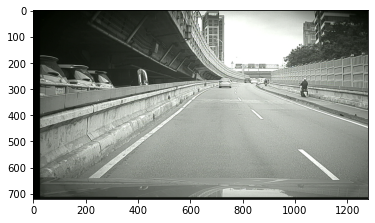

In [6]:
import cv2
import matplotlib.pyplot as plt 
img1 = cv2.cvtColor(cv2.imread('Elan_3d_box/image_2/000000.png'), cv2.COLOR_BGR2RGB)
print(img1.shape)
#img1 = cv2.imread('Elan_3d_box/image_2/000000.png')


plt.imshow(img1)

Elan_3d_box/renew_label\000777.txt


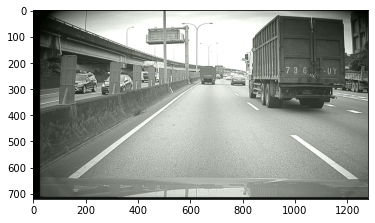

Elan_3d_box/renew_label\001640.txt


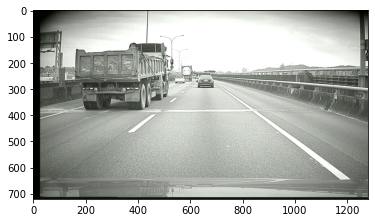

Elan_3d_box/renew_label\002029.txt


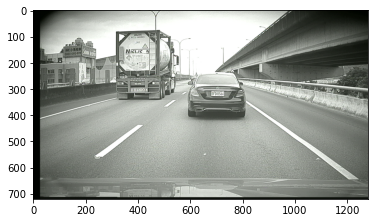

Elan_3d_box/renew_label\002051.txt


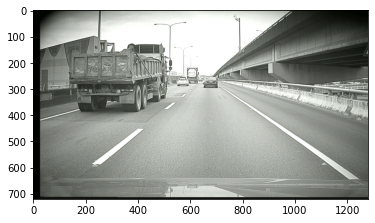

Elan_3d_box/renew_label\002052.txt


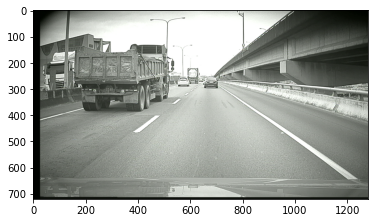

Elan_3d_box/renew_label\002053.txt


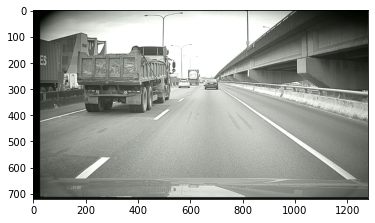

Elan_3d_box/renew_label\002054.txt


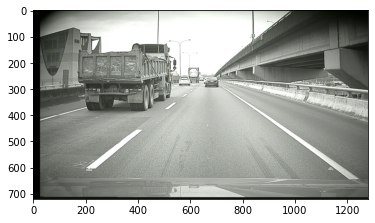

Elan_3d_box/renew_label\002055.txt


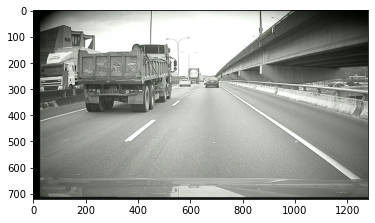

In [18]:
import glob, math
renew_labels = glob.glob('Elan_3d_box/renew_label/*.txt')
org_labels = glob.glob('Elan_3d_box/label_2/*.txt')
images = glob.glob('Elan_3d_box/image_2/*.png')

#cv2.cvtColor(cv2.imread('Elan_3d_box/image_2/000000.png'), cv2.COLOR_BGR2RGB)
for i in range(len(renew_labels)):
    lines = [x.strip() for x in open(renew_labels[i]).readlines()]
    min_top = 720
    max_btm = 0
    for line in lines:
        elements = line.split()
        left = int(round(float(elements[4])))
        top = int(round(float(elements[5])))
        right = int(round(float(elements[6])))
        btm = int(round(float(elements[7])))
        if top < min_top:
            min_top = top
            min_top_idx = i
        if btm > max_btm:
            max_btm = btm
            max_btm_idx = i
    if max_btm-min_top>360:
        print(renew_labels[i])
        plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))
        plt.show()
        
#print(min_top, min_top_idx)
#print(max_btm, max_btm_idx)
#print(max_btm-min_top)

In [9]:
print(renew_labels[max_btm_idx])

Elan_3d_box/renew_label\000391.txt


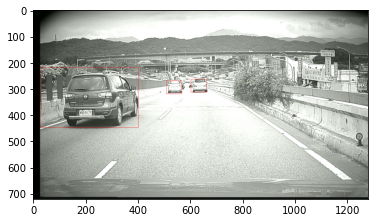

In [13]:
img = cv2.cvtColor(cv2.imread(images[max_btm_idx]), cv2.COLOR_BGR2RGB)
lines = [x.strip() for x in open(renew_labels[max_btm_idx]).readlines()]
for line in lines:
    elements = line.split()
    left = int(round(float(elements[4])))
    top = int(round(float(elements[5])))
    right = int(round(float(elements[6])))
    btm = int(round(float(elements[7])))
    cv2.rectangle(img, [left, top], [right, btm], (255,0,0), 1)
plt.imshow(img)

In [ ]:
## det3d/core/bbox/utils.py in mvc_monodet
def alpha_to_ry(location, alpha):
    ray = torch.atan2(location[:, 2], location[:, 0])
    ry = alpha + (-ray)
    ry = ry + 0.5 * math.pi
    ry = (ry + math.pi) % (2 * math.pi) - math.pi
    return ry

# 3dbbox
def bbox_alpha(bbox):
    roty = bbox.yaw #ry?
    location = bbox.center
    ray = torch.atan2(location[:, 2], location[:,0])
    alpha = roty - (-ray)
    pi = math.pi
    alpha = alpha - 0.5 * pi
    alpha = (alpha + pi) % (2 * pi) - pi
    return alpha

## IMAGE_3 box verification

In [ ]:
import glob
import matplotlib.pyplot as plt
import cv2
import os
index = 2 # 3
images = sorted(glob.glob(f'Kitti/training/image_{index}/*.png'))
labels = sorted(glob.glob(f'Kitti/training/label_{index}/*.txt'))
os.makedirs(f'Kitti/training/image_{index}_box', exist_ok=True)
for i in range(len(images)):
    lines = [x.strip() for x in open(labels[i]).readlines()]
    img = cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB)
    for line in lines:
        elements = line.split()
        left = int(round(float(elements[4])))
        top = int(round(float(elements[5])))
        right = int(round(float(elements[6])))
        btm = int(round(float(elements[7])))
        cv2.rectangle(img, [left, top], [right, btm], (255,0,0), 2)
    #plt.imshow(img)
    #plt.imsave()
    plt.imsave(images[i].replace(f'image_{index}', f'image_{index}_box'), img)
    #plt.show()

## Left label convert to right label

In [1]:
#https://github.com/HKUST-Aerial-Robotics/Stereo-RCNN/blob/63c6ab98b7a5e36c7bcfdec4529804fc940ee900/lib/model/utils/kitti_utils.py#L97C5-L97C25
import csv
class FrameCalibrationData:
    '''Frame Calibration Holder
        p0-p3      Camera P matrix. Contains extrinsic 3x4    
                   and intrinsic parameters.
        r0_rect    Rectification matrix, required to transform points 3x3    
                   from velodyne to camera coordinate frame.
        tr_velodyne_to_cam0     Used to transform from velodyne to cam 3x4    
                                coordinate frame according to:
                                Point_Camera = P_cam * R0_rect *
                                                Tr_velo_to_cam *
                                                Point_Velodyne.
    '''

    def __init__(self, calib_path):
        self.calib_path = calib_path
        self.p0 = []
        self.p1 = []
        self.p2 = []
        self.p3 = []
        self.p2_2 = []
        self.p2_3 = []
        self.r0_rect = []
        self.t_cam2_cam0 = []
        self.tr_velodyne_to_cam0 = []
        self.set_info(calib_path)
        
    def set_info(self, calib_path):
        ''' 
        Reads in Calibration file from Kitti Dataset.
        
        Inputs:
        CALIB_PATH : Str PATH of the calibration file.
        
        Returns:
        frame_calibration_info : FrameCalibrationData
                                Contains a frame's full calibration data.
        ^ z        ^ z                                      ^ z         ^ z
        | cam2     | cam0                                   | cam3      | cam1
        |-----> x  |-----> x                                |-----> x   |-----> x

        '''
        data_file = open(calib_path, 'r')
        data_reader = csv.reader(data_file, delimiter=' ')
        data = []

        for row in data_reader:
            data.append(row)

        data_file.close()

        p_all = []

        for i in range(4):
            p = data[i]
            p = p[1:]
            p = [float(p[i]) for i in range(len(p))]
            p = np.reshape(p, (3, 4))
            p_all.append(p)

        # based on camera 0
        self.p0 = p_all[0]
        self.p1 = p_all[1]
        self.p2 = p_all[2]
        self.p3 = p_all[3]

        # based on camera 2
        self.p2_2 = np.copy(p_all[2]) 
        self.p2_2[0,3] = self.p2_2[0,3] - self.p2[0,3]

        self.p2_3 = np.copy(p_all[3]) 
        self.p2_3[0,3] = self.p2_3[0,3] - self.p2[0,3]

        self.t_cam2_cam0 = np.zeros(3)
        self.t_cam2_cam0[0] = (self.p2[0,3] - self.p0[0,3])/self.p2[0,0]

        # Read in rectification matrix
        tr_rect = data[4]
        tr_rect = tr_rect[1:]
        tr_rect = [float(tr_rect[i]) for i in range(len(tr_rect))]
        self.r0_rect = np.reshape(tr_rect, (3, 3))

        # Read in velodyne to cam matrix
        tr_v2c = data[5]
        tr_v2c = tr_v2c[1:]
        tr_v2c = [float(tr_v2c[i]) for i in range(len(tr_v2c))]
        self.tr_velodyne_to_cam0 = np.reshape(tr_v2c, (3, 4))

In [2]:
import glob
import cv2
import os
import numpy as np
from library.Math import create_corners, rotation_matrix
from library.Plotting import project_3d_pt, plot_3d_box

calib = sorted(glob.glob(f'Kitti/training/calib/*.txt'))
images_2 = sorted(glob.glob(f'Kitti/training/image_2/*.png'))
labels_2 = sorted(glob.glob(f'Kitti/training/label_2/*.txt'))
os.makedirs('Kitti/training/label_3', exist_ok=True)
for i in range(len(images_2)):
    lines = [x.strip() for x in open(labels_2[i]).readlines()]
    img = cv2.cvtColor(cv2.imread(images_2[i]), cv2.COLOR_BGR2RGB)
    cam_to_img = FrameCalibrationData(calib[i])
    H, W, _ = img.shape
    label_3 = ''
    for line in lines:
        #LABEL_2
        elements = line.split()
        class_ = elements[0]
        if elements[0] == 'DontCare':
            continue
        for j in range(1,len(elements)):
            elements[j] = float(elements[j])
        truncated = elements[1]
        occluded = elements[2]
        alpha = elements[3]
        left = int(round(elements[4]))
        top = int(round(elements[5]))
        right = int(round(elements[6]))
        btm = int(round(elements[7]))
        dim = [elements[8], elements[9], elements[10]]
        loc = [elements[11], elements[12], elements[13]]
        ry = elements[14]
        # calc box_2d of image_3
        X = list()
        Y = list()
        R = rotation_matrix(ry)
        #https://github.com/HKUST-Aerial-Robotics/Stereo-RCNN/blob/63c6ab98b7a5e36c7bcfdec4529804fc940ee900/lib/model/utils/kitti_utils.py#L195C68-L195C86
        loc_correction = loc + cam_to_img.t_cam2_cam0 #3d location is for cam0, need to add relative cam2_cam0 distance
        loc_correction[1] -= dim[0]/2 # move to center
        corners_3d = create_corners(dim, loc_correction, R)
        for pt_3d in corners_3d:
            pt_2d = project_3d_pt(pt_3d, cam_to_img.p2_3) #proj by calib_2_3
            X.append(pt_2d[0])
            Y.append(pt_2d[1])
        left = max(min(X),0)
        right = min(max(X), W-1)
        top = max(min(Y), 0)
        btm = min(max(Y), H-1)
        
        label_3 += '{CLASS} {T:.1f} {O} {A:.2f} {left} {top} {right} {btm} {H:.2f} {W:.2f} {L:.2f} {X:.2f} {Y:.2f} {Z:.2f} {Ry:.2f}\n'.format(
                    CLASS=class_, T=truncated, O=occluded, A=alpha, left=left, top=top, right=right, btm=btm,
                    H=dim[0], W=dim[1], L=dim[2], X=loc[0], Y=loc[1], Z=loc[2], Ry=ry)
        
    with open(labels_2[i].replace('label_2', 'label_3'), 'w') as f:
        f.writelines(label_3)

In [10]:
import matplotlib.pyplot as plt
calib = sorted(glob.glob(f'Kitti/training/calib/*.txt'))
images_2 = sorted(glob.glob(f'Kitti/training/image_3/*.png'))
labels_2 = sorted(glob.glob(f'Kitti/training/label_3/*.txt'))
os.makedirs('Kitti/training/label_3', exist_ok=True)
for i in range(20):#(len(images_2)):
    lines = [x.strip() for x in open(labels_2[i]).readlines()]
    img = cv2.cvtColor(cv2.imread(images_2[i]), cv2.COLOR_BGR2RGB)
    cam_to_img = FrameCalibrationData(calib[i])
    H, W, _ = img.shape
    label_3 = ''
    for line in lines:
        #LABEL_2
        plt.figure(200,100)
        elements = line.split()
        class_ = elements[0]
        if elements[0] == 'DontCare':
            continue
        for j in range(1,len(elements)):
            elements[j] = float(elements[j])
        truncated = elements[1]
        occluded = elements[2]
        alpha = elements[3]
        left = int(round(elements[4]))
        top = int(round(elements[5]))
        right = int(round(elements[6]))
        btm = int(round(elements[7]))
        cv2.rectangle(img, [left, top], [right, btm], (255,0,0), 2)
        print([left, top], [right, btm])
        
    plt.imshow(img)
    plt.show()

TypeError: from_bounds() argument after * must be an iterable, not int